In [1]:
%pwd

'/home/acr/Documents/Projeto Sistemas Mecatrónicos/RL-SistMecatron/Resultados e Código para Relatório'

# Only runs on Python 3.7 because of the stableBaselines

# Building our own scenario

Build a reinforcement learning model to adjust the temperature automatically to get in the optimal range

Optimal temperature: Between 37 and 39 degrees
Shower Length: 60 seconds
Actions: Turn down, Leave, Turn up
Task: Build a model that keeps us in the optimal range for as long as possible

# Install Dependencies

In [33]:
!pip install tensorflow==2.3.0
!pip install gym
!pip install keras
!pip install keras-rl2
!pip install tensorflow-gpu==2.3.0 
!pip install stable_baselines 
!pip install gym
!conda install swig -y # needed to build Box2D in the pip install
!pip install box2d-py # a repackaged version of pybox2d

ERROR: Could not find a version that satisfies the requirement tensorflow==2.3.0 (from versions: 2.5.0rc0, 2.5.0rc1, 2.5.0rc2, 2.5.0rc3, 2.5.0, 2.5.1, 2.5.2, 2.6.0rc0, 2.6.0rc1, 2.6.0rc2, 2.6.0, 2.6.1, 2.6.2, 2.7.0rc0, 2.7.0rc1, 2.7.0)
ERROR: No matching distribution found for tensorflow==2.3.0


# Creating a random environment

#### The goal is to balance the pole up, moving the cart to the left or right . For each step it takes a point, for a maximum of 200 points

In [92]:
from gym import Env # Allows us to build our environment on top of it
from gym import spaces
from gym.spaces import Discrete, Box # Allows us to define the actions and the states of our environment
import numpy as np
import random
import time
import matplotlib.pyplot as plt

In [93]:
class ShowerEnv(Env): # By passing Env to the showerEnv class we are inheriting the methods and properties from the OpenAI gym environment class
    metadata = {'render.modes': ['console']}
    
    def __init__(self): # We will be initializing the actions we can take, our observation space, the space, the temperature and the shower length 
        super(ShowerEnv,self).__init__()
        # Actions we can take, down, stay, up
        self.action_space=spaces.Discrete(3)
        # Temperature array
        self.observation_space = Box(low=0, high=100, shape=(1,), dtype=np.float32) # Box allows to gave a whole range of spaces
        # Set start temp (As in real life, the shower's water starts cold)
        self.state = 15 + random.randint(-3,3)
        # Set shower length
        self.shower_length = 60*5 # 10 minutes=10*60 seconds

    def reset(self):
        # Reset shower temperature
        self.state = 15 +random.randint(-3,3)
        # Reset shower time
        self.shower_length = 60*5
        return np.array([self.state]).astype(np.float32)
    
    def step(self, action): # Defines what we do whenever we take actions
        # Aplly action
        # As the action is 0,1 or 2, as we subtract 1 when temperature decreases is -1, when it stays the same is 0 and when it increases is +1
        # 0-1=-1, 1-1=0, 2-1=1
        self.state += action -1
        # Reduce shower length by 1 second
        self.shower_length -= 1
        
        #Calculate reward
        # If water is 38 it gives a reward of 2, if it is 37 or 29 it gives a reward of 1
        if self.state>= 37 and self.state<=39:
            reward= (2-abs(38-self.state))*6
        # The negative rewards will be greater if the colder the water is and the hotter the water is 
        elif self.state < 37:
            reward=-(37-self.state)*2
        elif self.state > 39:
            reward = -(self.state-39)*2
        
        # Check if shower is done
        if self.shower_length <=0 :
            done = True
        else:
            done = False                
        
        # Apply temperature noise
#         self.state+=random.randint(-2,2)
        # Set placeholder for info
        info= {}
        
        # Return step information
        return np.array([self.state]).astype(np.float32), reward, done, info # self.state is the temperature
    
    def render(self): # Visualizations
        # Implement visualization
        pass
    
    def close(self):
        pass

In [94]:
env = ShowerEnv()

In [95]:
# help(env.step)

In [96]:
env.step(1)[0]

array([14.], dtype=float32)

In [97]:
env.action_space.sample()

1

In [98]:
env.observation_space.high[0]

100.0

In [99]:
env.observation_space.sample()

array([44.349606], dtype=float32)

#### Now we're just setting some random episodes where there is no learning from each of the episodes

Box([0.], [100.], (1,), float32)
Discrete(3)
0

Episode:1 Score: -3864 
Episode:2 Score: -15068 
Episode:3 Score: -14050 
Episode:4 Score: -15278 
Episode:5 Score: -9184 
Episode:6 Score: -23010 
Episode:7 Score: -13550 
Episode:8 Score: -11742 
Episode:9 Score: -13070 
Episode:10 Score: -12498 


<function matplotlib.pyplot.show(close=None, block=None)>

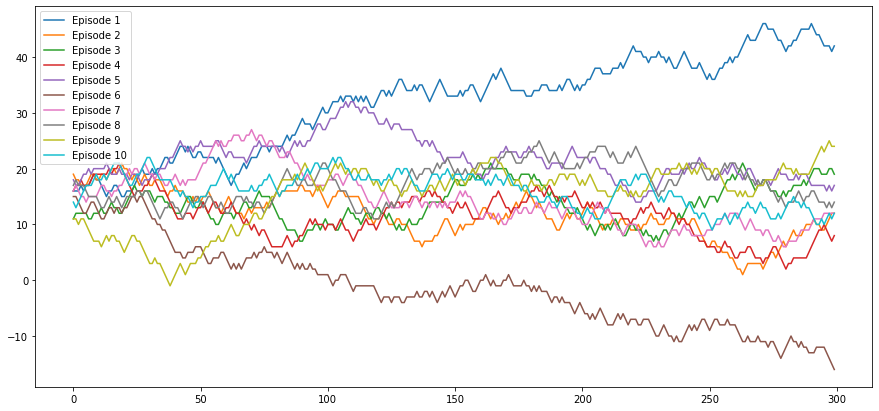

In [100]:
obs = env.reset()

print(env.observation_space)
print(env.action_space)
print(env.action_space.sample())
print()

plt.figure(figsize=(15,7))
episodes = 10
for episode in range(1,episodes+1):
  state=env.reset()
  done=False
  score=0
  Temp_plot=[]

  while not done:
#     env.render() # Rendering of the screen
#     time.sleep(0.03) # Slowing the rendering. It stops 0.03 seconds for each frame
    action = env.action_space.sample()
    obs, reward, done, info = env.step(action)
    Temp_plot.append(obs)
    score+=reward
    info = info
    
  plt.plot(Temp_plot, label = 'Episode {}'.format(episode))
  plt.legend()
  print('Episode:{} Score: {} '.format(episode, round(score,0)))
plt.show
# env.close()   # Closing the video, otherwise the window will not close

In [101]:
# help(env.step)

# Build Agent with StableBaselines

In [102]:
from stable_baselines.common.vec_env import DummyVecEnv
from stable_baselines.deepq.policies import MlpPolicy
from stable_baselines import DQN
from stable_baselines.common.env_checker import check_env
from stable_baselines.common.cmd_util import make_vec_env

Checking if the environment follows the gym interface

In [103]:
# It will check your custom environment and output additional warnings if needed
check_env(env, warn=True)

In [104]:
# help(DQN)

In [105]:
env = make_vec_env(lambda: env, n_envs=1)

In [106]:
model1 = DQN('MlpPolicy', env, verbose=1).learn(15000)


State: None
Action:  1
State 18.0 reward= -38.0 done= [False]
Sum of rewards: -38.0
Step: 1

State: None
Action:  1
State 19.0 reward= -36.0 done= [False]
Sum of rewards: -74.0
Step: 2

State: None
Action:  1
State 20.0 reward= -34.0 done= [False]
Sum of rewards: -108.0
Step: 3

State: None
Action:  1
State 21.0 reward= -32.0 done= [False]
Sum of rewards: -140.0
Step: 4

State: None
Action:  1
State 22.0 reward= -30.0 done= [False]
Sum of rewards: -170.0
Step: 5

State: None
Action:  1
State 23.0 reward= -28.0 done= [False]
Sum of rewards: -198.0
Step: 6

State: None
Action:  1
State 24.0 reward= -26.0 done= [False]
Sum of rewards: -224.0
Step: 7

State: None
Action:  1
State 25.0 reward= -24.0 done= [False]
Sum of rewards: -248.0
Step: 8

State: None
Action:  1
State 26.0 reward= -22.0 done= [False]
Sum of rewards: -270.0
Step: 9

State: None
Action:  1
State 27.0 reward= -20.0 done= [False]
Sum of rewards: -290.0
Step: 10

State: None
Action:  1
State 28.0 reward= -18.0 done= [False

State 38.0 reward= 12.0 done= [False]
Sum of rewards: 808.0
Step: 151

State: None
Action:  -1
State 37.0 reward= 6.0 done= [False]
Sum of rewards: 814.0
Step: 152

State: None
Action:  1
State 38.0 reward= 12.0 done= [False]
Sum of rewards: 826.0
Step: 153

State: None
Action:  -1
State 37.0 reward= 6.0 done= [False]
Sum of rewards: 832.0
Step: 154

State: None
Action:  1
State 38.0 reward= 12.0 done= [False]
Sum of rewards: 844.0
Step: 155

State: None
Action:  -1
State 37.0 reward= 6.0 done= [False]
Sum of rewards: 850.0
Step: 156

State: None
Action:  1
State 38.0 reward= 12.0 done= [False]
Sum of rewards: 862.0
Step: 157

State: None
Action:  -1
State 37.0 reward= 6.0 done= [False]
Sum of rewards: 868.0
Step: 158

State: None
Action:  1
State 38.0 reward= 12.0 done= [False]
Sum of rewards: 880.0
Step: 159

State: None
Action:  -1
State 37.0 reward= 6.0 done= [False]
Sum of rewards: 886.0
Step: 160

State: None
Action:  1
State 38.0 reward= 12.0 done= [False]
Sum of rewards: 898.0



State: None
Action:  1
State 38.0 reward= 12.0 done= [False]
Sum of rewards: 2104.0
Step: 295

State: None
Action:  -1
State 37.0 reward= 6.0 done= [False]
Sum of rewards: 2110.0
Step: 296

State: None
Action:  1
State 38.0 reward= 12.0 done= [False]
Sum of rewards: 2122.0
Step: 297

State: None
Action:  -1
State 37.0 reward= 6.0 done= [False]
Sum of rewards: 2128.0
Step: 298

State: None
Action:  1
State 38.0 reward= 12.0 done= [False]
Sum of rewards: 2140.0
Step: 299

State: None
Action:  -1
State 12.0 reward= 6.0 done= [ True]
Sum of rewards: 2146.0
Step: 300


<function matplotlib.pyplot.show(close=None, block=None)>

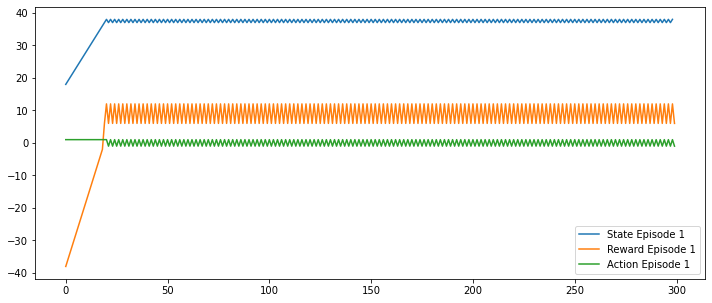

In [107]:
episodes =1
for episode in range(1,episodes+1):
  obs=env.reset()
  done=False
  state_batch = []
  reward_batch = []
  action_batch = []
  total_rewards = 0
  total_rewards_list= []
  step = 0
    
  while not done:
    step+=1
    action, obs = model1.predict(obs)
    print('\nState:',obs)
    print("Action: ", action[0]-1)
    action_batch.append(action-1)
    obs, rewards, done, info = env.step(action)
    print('State', obs[0][0], 'reward=', rewards[0], 'done=', done)
    state_batch.append(obs[0][0])
    reward_batch.append(rewards)
    total_rewards += rewards
    total_rewards_list.append(total_rewards[0])
    print('Sum of rewards:', total_rewards[0])
    print('Step:', step)

  plt.figure(figsize=(12,5))  
  plt.plot(state_batch[:-1], label='State Episode {}'.format(episode))
  plt.plot(reward_batch,label='Reward Episode {}'.format(episode))
  plt.plot(action_batch, label='Action Episode {}'.format(episode))
#   plt.plot(total_rewards_list, label='Sum of rewards Episode {}'.format(episode))
  plt.legend()
plt.show

In [108]:
# print(state_batch)

In [114]:
# model2 = DQN('MlpPolicy', env, verbose=1).learn(120000)

--------------------------------------
| % time spent exploring  | 2        |
| episodes                | 100      |
| mean 100 episode reward | -423     |
| steps                   | 29700    |
--------------------------------------
--------------------------------------
| % time spent exploring  | 2        |
| episodes                | 200      |
| mean 100 episode reward | 1.97e+03 |
| steps                   | 59700    |
--------------------------------------
--------------------------------------
| % time spent exploring  | 2        |
| episodes                | 300      |
| mean 100 episode reward | 1.59e+03 |
| steps                   | 89700    |
--------------------------------------
--------------------------------------
| % time spent exploring  | 2        |
| episodes                | 400      |
| mean 100 episode reward | 1.43e+03 |
| steps                   | 119700   |
--------------------------------------


In [118]:
model2 = DQN.load("DQN_RL_Example_Custom_Scenario_Variations_1action_NoNoise_Baselines_RewardsTweak_model_120kSteps", env=env)


State: None
Action:  1
State 16.0 reward= -42.0 done= [False]
Sum of rewards: -42.0
Step: 1

State: None
Action:  1
State 17.0 reward= -40.0 done= [False]
Sum of rewards: -82.0
Step: 2

State: None
Action:  1
State 18.0 reward= -38.0 done= [False]
Sum of rewards: -120.0
Step: 3

State: None
Action:  1
State 19.0 reward= -36.0 done= [False]
Sum of rewards: -156.0
Step: 4

State: None
Action:  1
State 20.0 reward= -34.0 done= [False]
Sum of rewards: -190.0
Step: 5

State: None
Action:  1
State 21.0 reward= -32.0 done= [False]
Sum of rewards: -222.0
Step: 6

State: None
Action:  1
State 22.0 reward= -30.0 done= [False]
Sum of rewards: -252.0
Step: 7

State: None
Action:  1
State 23.0 reward= -28.0 done= [False]
Sum of rewards: -280.0
Step: 8

State: None
Action:  1
State 24.0 reward= -26.0 done= [False]
Sum of rewards: -306.0
Step: 9

State: None
Action:  1
State 25.0 reward= -24.0 done= [False]
Sum of rewards: -330.0
Step: 10

State: None
Action:  1
State 26.0 reward= -22.0 done= [False


State: None
Action:  0
State 38.0 reward= 12.0 done= [False]
Sum of rewards: 1152.0
Step: 156

State: None
Action:  0
State 38.0 reward= 12.0 done= [False]
Sum of rewards: 1164.0
Step: 157

State: None
Action:  0
State 38.0 reward= 12.0 done= [False]
Sum of rewards: 1176.0
Step: 158

State: None
Action:  0
State 38.0 reward= 12.0 done= [False]
Sum of rewards: 1188.0
Step: 159

State: None
Action:  0
State 38.0 reward= 12.0 done= [False]
Sum of rewards: 1200.0
Step: 160

State: None
Action:  0
State 38.0 reward= 12.0 done= [False]
Sum of rewards: 1212.0
Step: 161

State: None
Action:  0
State 38.0 reward= 12.0 done= [False]
Sum of rewards: 1224.0
Step: 162

State: None
Action:  0
State 38.0 reward= 12.0 done= [False]
Sum of rewards: 1236.0
Step: 163

State: None
Action:  0
State 38.0 reward= 12.0 done= [False]
Sum of rewards: 1248.0
Step: 164

State: None
Action:  0
State 38.0 reward= 12.0 done= [False]
Sum of rewards: 1260.0
Step: 165

State: None
Action:  0
State 38.0 reward= 12.0 do

<function matplotlib.pyplot.show(close=None, block=None)>

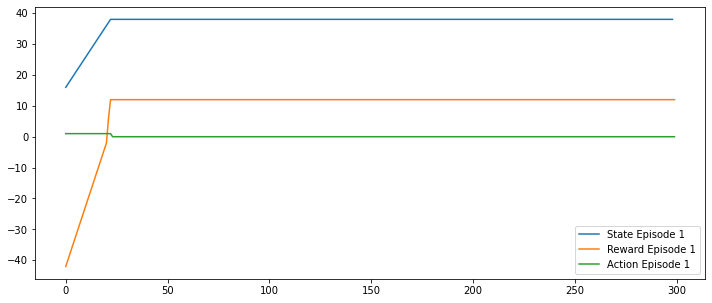

In [120]:
episodes =1
for episode in range(1,episodes+1):
  obs=env.reset()
  done=False
  state_batch = []
  reward_batch = []
  action_batch = []
  total_rewards = 0
  total_rewards_list= []
  step = 0
    
  while not done:
    step+=1
    action, obs = model2.predict(obs)
    print('\nState:',obs)
    print("Action: ", action[0]-1)
    action_batch.append(action-1)
    obs, rewards, done, info = env.step(action)
    print('State', obs[0][0], 'reward=', rewards[0], 'done=', done)
    state_batch.append(obs[0][0])
    reward_batch.append(rewards)
    total_rewards += rewards
    total_rewards_list.append(total_rewards[0])
    print('Sum of rewards:', total_rewards[0])
    print('Step:', step)

  plt.figure(figsize=(12,5))  
  plt.plot(state_batch[:-1], label='State Episode {}'.format(episode))
  plt.plot(reward_batch,label='Reward Episode {}'.format(episode))
  plt.plot(action_batch, label='Action Episode {}'.format(episode))
#   plt.plot(total_rewards_list, label='Sum of rewards Episode {}'.format(episode))
  plt.legend()
plt.show

In [116]:
model2.save("DQN_RL_Example_Custom_Scenario_Variations_1action_NoNoise_Baselines_RewardsTweak_model_120kSteps")

In [117]:
del model2

In [ ]:
# model2=DQN.load("DQN_RL_Example_Custom_Scenario_Variations_1action_NoNoise_Baselines_RewardsTweak_model_120kSteps")

# Create a Deep Learning Model with Keras

#### Ideally we want to take the score of each episode all the way up to 200. The deep RL is going to learn the best action to take in that specific environment to maximize the score

In [ ]:
import numpy as np
import tensorflow  #allows a sequential model with Keras
# It's better to import tensorflow and use sequential than specifically importing the sequential from tensorlfow.keras.model
from tensorflow.keras.layers import Dense, Flatten # We've imported the dense and flattten nodes
from tensorflow.keras.optimizers import Adam # We've imported the optimizer Adam to train the deep learning model

In [ ]:
states = env.observation_space.shape
actions = env.action_space.n

In [ ]:
states

In [ ]:
env.observation_space

In [ ]:
def build_model3layers(states, actions):
  model = tensorflow.keras.Sequential()  # initiating a sequential model
  model.add(Dense(24, activation='relu', input_shape=states))
  model.add(Dense(24, activation='relu'))
  model.add(Dense(24, activation='relu'))
  model.add(Dense(actions, activation='linear')) # This makes sure that the output are the actions. First (or through the top), come the states and lastly comes the acitons
  return model
# This model is fed the states and gets out the actions, and it trains in order to maximize the reward

In [ ]:
del model_a

In [ ]:
model_a = build_model3layers(states,actions)

In [ ]:
model_a.summary() # The final output will have 3 actions. Decreasing, staying the same and increasing the temperature